In [6]:
"""
Demographic Stratification Analysis
This notebook performs comprehensive demographic stratification to understand how
metabolic patterns vary across population subgroups. It provides:
1. Stratification of core metabolic variables by demographics
2. Statistical testing for group differences
3. Interaction analysis (age × sex, age × race/ethnicity)
4. MetS prevalence by demographic subgroups
5. Identification of high-risk populations

"""

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Pastel color palettes
pastel_colors = ['#FFB6C1', '#B0E0E6', '#DDA0DD', '#F0E68C', '#98FB98', 
                 '#FFE4B5', '#E6E6FA', '#FFC0CB']
sns.set_palette(pastel_colors)




In [7]:
# Load Data

# Load the enhanced dataset with MetS variables
df = pd.read_csv("../../data/processed/nhanes_metabolic_with_mets.csv")

print(f"\n✓ Loaded data: {df.shape[0]:,} participants × {df.shape[1]} variables")

# Core variables for analysis
core_vars = ['LBXGLU', 'LBXTLG', 'BMXWAIST']
demographic_vars = ['age_group', 'sex_label', 'RIDAGEYR', 'RIAGENDR']
mets_vars = ['mets_score', 'mets_full', 'mets_partial', 'mets_combination']

print(f"\nCore metabolic variables: {core_vars}")
print(f"Demographic variables: {demographic_vars}")
print(f"MetS variables: {mets_vars}")

# Check available race/ethnicity variables
race_cols = [col for col in df.columns if 'RIDRETH' in col or 'race' in col.lower()]
print(f"\nAvailable race/ethnicity variables: {race_cols}")

# Create race/ethnicity labels if not already present
if 'race_ethnicity' not in df.columns:
    race_map = {
        1: 'Mexican American',
        2: 'Other Hispanic',
        3: 'Non-Hispanic White',
        4: 'Non-Hispanic Black',
        6: 'Non-Hispanic Asian',
        7: 'Other/Multiracial'
    }
    
    if 'RIDRETH3' in df.columns:
        df['race_ethnicity'] = df['RIDRETH3'].map(race_map)
        print(f"\n✓ Created race_ethnicity variable from RIDRETH3")
    elif 'RIDRETH1' in df.columns:
        race_map_simple = {
            1: 'Mexican American',
            2: 'Other Hispanic', 
            3: 'Non-Hispanic White',
            4: 'Non-Hispanic Black',
            5: 'Other/Multiracial'
        }
        df['race_ethnicity'] = df['RIDRETH1'].map(race_map_simple)
        print(f"\n✓ Created race_ethnicity variable from RIDRETH1")

# Display demographic distribution
print("\n" + "="*80)
print("DEMOGRAPHIC DISTRIBUTION")
print("="*80)

print("\nAge Groups:")
print(df['age_group'].value_counts().sort_index())

print("\nSex:")
print(df['sex_label'].value_counts())

if 'race_ethnicity' in df.columns:
    print("\nRace/Ethnicity:")
    print(df['race_ethnicity'].value_counts())

print("\n✓ Data loaded and demographic variables verified")


✓ Loaded data: 3,047 participants × 50 variables

Core metabolic variables: ['LBXGLU', 'LBXTLG', 'BMXWAIST']
Demographic variables: ['age_group', 'sex_label', 'RIDAGEYR', 'RIAGENDR']
MetS variables: ['mets_score', 'mets_full', 'mets_partial', 'mets_combination']

Available race/ethnicity variables: ['RIDRETH1', 'RIDRETH3']

✓ Created race_ethnicity variable from RIDRETH3

DEMOGRAPHIC DISTRIBUTION

Age Groups:
age_group
18-29     399
30-44     646
45-59     629
60+      1373
Name: count, dtype: int64

Sex:
sex_label
Female    1663
Male      1384
Name: count, dtype: int64

Race/Ethnicity:
race_ethnicity
Non-Hispanic White    1826
Non-Hispanic Black     323
Other Hispanic         322
Mexican American       230
Other/Multiracial      179
Non-Hispanic Asian     167
Name: count, dtype: int64

✓ Data loaded and demographic variables verified


In [ ]:
# Descriptive Statistics by Demographics

# Function to calculate descriptive stats
def demographic_summary(data, var, group_var, group_name):
    """Calculate mean, SD, median, IQR for a variable by demographic group"""
    summary = data.groupby(group_var)[var].agg([
        ('N', 'count'),
        ('Mean', 'mean'),
        ('SD', 'std'),
        ('Median', 'median'),
        ('Q1', lambda x: x.quantile(0.25)),
        ('Q3', lambda x: x.quantile(0.75)),
        ('Min', 'min'),
        ('Max', 'max')
    ]).round(2)
    
    print(f"\n{var} by {group_name}:")
    print(summary.to_string())
    return summary

# Create a dictionary to store all summaries
summaries = {}

# By Age Group
print("\n" + "="*50)
print("STRATIFICATION BY AGE GROUP")
print("="*50)
for var in core_vars:
    summaries[f'{var}_by_age'] = demographic_summary(df, var, 'age_group', 'Age Group')

# By Sex
print("\n" + "="*50)
print("STRATIFICATION BY SEX")
print("="*50)
for var in core_vars:
    summaries[f'{var}_by_sex'] = demographic_summary(df, var, 'sex_label', 'Sex')

# By Race/Ethnicity
if 'race_ethnicity' in df.columns:
    print("STRATIFICATION BY RACE/ETHNICITY")
    for var in core_vars:
        summaries[f'{var}_by_race'] = demographic_summary(df, var, 'race_ethnicity', 'Race/Ethnicity')


STRATIFICATION BY AGE GROUP

LBXGLU by Age Group:
              N    Mean     SD  Median    Q1     Q3   Min    Max
age_group                                                       
18-29       399   97.96  27.11    95.0  90.0  101.0  67.0  417.0
30-44       646  101.54  25.53    97.0  92.0  103.0  69.0  349.0
45-59       629  114.18  43.77   102.0  95.0  113.0  59.0  561.0
60+        1373  113.28  31.16   105.0  98.0  117.0  59.0  460.0

LBXTLG by Age Group:
              N    Mean      SD  Median    Q1      Q3   Min     Max
age_group                                                          
18-29       399   92.22   57.97    77.0  55.0  110.00  27.0   577.0
30-44       646  117.35   97.38    97.0  68.0  137.75  25.0  1658.0
45-59       629  137.68  120.24   106.0  79.0  154.00  28.0  1745.0
60+        1373  121.33   67.75   104.0  78.0  146.00  27.0   671.0

BMXWAIST by Age Group:
              N    Mean     SD  Median     Q1      Q3   Min    Max
age_group                             

In [ ]:
#  Statistical Testing - Age Groups (ANOVA)

# Perform one-way ANOVA for each core variable
anova_results = []

for var in core_vars:
    # Get data by age group
    age_groups = df['age_group'].unique()
    groups_data = [df[df['age_group']==ag][var].dropna().values for ag in age_groups]
    
    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(*groups_data)
    
    # Calculate effect size (eta-squared)
    # eta² = SSbetween / SStotal
    grand_mean = df[var].mean()
    ss_between = sum([len(df[df['age_group']==ag]) * (df[df['age_group']==ag][var].mean() - grand_mean)**2 
                      for ag in age_groups])
    ss_total = sum((df[var] - grand_mean)**2)
    eta_squared = ss_between / ss_total
    
    anova_results.append({
        'Variable': var,
        'F_statistic': f_stat,
        'p_value': p_val,
        'eta_squared': eta_squared,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })
    
    print(f"\n{var}:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  P-value: {p_val:.4e}")
    print(f"  Eta-squared (effect size): {eta_squared:.3f}")
    if p_val < 0.001:
        print(f"  *** Highly significant (p < 0.001)")
    elif p_val < 0.05:
        print(f"  ** Significant (p < 0.05)")
    else:
        print(f"  Not significant (p ≥ 0.05)")

# Create summary table
anova_df = pd.DataFrame(anova_results)
print("ANOVA SUMMARY TABLE")
print(anova_df.to_string(index=False))

# Post-hoc tests (Tukey HSD) for significant results
print("POST-HOC TESTS (TUKEY HSD)")

posthoc_results = {}
for var in core_vars:
    # Check if ANOVA was significant
    if anova_df[anova_df['Variable']==var]['Significant'].values[0] == 'Yes':
        print(f"\n{var}:")
        
        # Prepare data for Tukey HSD
        data_for_tukey = df[['age_group', var]].dropna()
        
        # Perform Tukey HSD
        tukey = pairwise_tukeyhsd(endog=data_for_tukey[var], 
                                   groups=data_for_tukey['age_group'], 
                                   alpha=0.05)
        
        print(tukey)
        posthoc_results[var] = tukey
    else:
        print(f"\n{var}: ANOVA not significant, post-hoc test not needed")


LBXGLU:
  F-statistic: 39.556
  P-value: 4.5271e-25
  Eta-squared (effect size): 0.038
  *** Highly significant (p < 0.001)

LBXTLG:
  F-statistic: 22.722
  P-value: 1.5190e-14
  Eta-squared (effect size): 0.022
  *** Highly significant (p < 0.001)

BMXWAIST:
  F-statistic: 59.845
  P-value: 1.3808e-37
  Eta-squared (effect size): 0.056
  *** Highly significant (p < 0.001)
ANOVA SUMMARY TABLE
Variable  F_statistic      p_value  eta_squared Significant
  LBXGLU    39.556041 4.527085e-25     0.037533         Yes
  LBXTLG    22.722000 1.518969e-14     0.021910         Yes
BMXWAIST    59.845238 1.380806e-37     0.055713         Yes
POST-HOC TESTS (TUKEY HSD)

LBXGLU:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 18-29  30-44   3.5782 0.3133 -1.7689  8.9253  False
 18-29  45-59  16.2254    0.0 10.8508 21.6001   True
 18-29    60+  15.3201    0.0  10.544 20.0962   True
 30-44  4

In [ ]:
# Statistical Testing - Sex Differences (t-tests)
# Perform independent t-tests for each core variable
ttest_results = []

for var in core_vars:
    # Get data by sex
    male_data = df[df['sex_label']=='Male'][var].dropna().values
    female_data = df[df['sex_label']=='Female'][var].dropna().values
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(male_data, female_data)
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(male_data)-1)*np.std(male_data, ddof=1)**2 + 
                          (len(female_data)-1)*np.std(female_data, ddof=1)**2) / 
                         (len(male_data) + len(female_data) - 2))
    cohens_d = (np.mean(male_data) - np.mean(female_data)) / pooled_std
    
    # Mean difference
    mean_diff = np.mean(male_data) - np.mean(female_data)
    
    ttest_results.append({
        'Variable': var,
        'Male_Mean': np.mean(male_data),
        'Female_Mean': np.mean(female_data),
        'Mean_Difference': mean_diff,
        't_statistic': t_stat,
        'p_value': p_val,
        'Cohens_d': cohens_d,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })
    
    print(f"\n{var}:")
    print(f"  Male mean: {np.mean(male_data):.2f} (SD: {np.std(male_data, ddof=1):.2f})")
    print(f"  Female mean: {np.mean(female_data):.2f} (SD: {np.std(female_data, ddof=1):.2f})")
    print(f"  Mean difference: {mean_diff:.2f}")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_val:.4e}")
    print(f"  Cohen's d (effect size): {cohens_d:.3f}")
    
    if abs(cohens_d) < 0.2:
        effect = "negligible"
    elif abs(cohens_d) < 0.5:
        effect = "small"
    elif abs(cohens_d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    print(f"  Effect size interpretation: {effect}")
    
    if p_val < 0.001:
        print(f"  *** Highly significant (p < 0.001)")
    elif p_val < 0.05:
        print(f"  ** Significant (p < 0.05)")
    else:
        print(f"  Not significant (p ≥ 0.05)")

# Create summary table
ttest_df = pd.DataFrame(ttest_results)
print("\n" + "="*80)
print("T-TEST SUMMARY TABLE")
print("="*80)
print(ttest_df.round(3).to_string(index=False))


LBXGLU:
  Male mean: 113.54 (SD: 38.03)
  Female mean: 105.16 (SD: 28.20)
  Mean difference: 8.38
  t-statistic: 6.971
  P-value: 3.8331e-12
  Cohen's d (effect size): 0.254
  Effect size interpretation: small
  *** Highly significant (p < 0.001)

LBXTLG:
  Male mean: 126.48 (SD: 105.11)
  Female mean: 114.70 (SD: 69.21)
  Mean difference: 11.78
  t-statistic: 3.705
  P-value: 2.1528e-04
  Cohen's d (effect size): 0.135
  Effect size interpretation: negligible
  *** Highly significant (p < 0.001)

BMXWAIST:
  Male mean: 103.03 (SD: 16.38)
  Female mean: 98.23 (SD: 16.83)
  Mean difference: 4.80
  t-statistic: 7.930
  P-value: 3.0472e-15
  Cohen's d (effect size): 0.289
  Effect size interpretation: small
  *** Highly significant (p < 0.001)

T-TEST SUMMARY TABLE
Variable  Male_Mean  Female_Mean  Mean_Difference  t_statistic  p_value  Cohens_d Significant
  LBXGLU    113.541      105.164            8.378        6.971      0.0     0.254         Yes
  LBXTLG    126.476      114.700      

In [ ]:
# tatistical Testing - Sex Differences (t-tests)

# Perform independent t-tests for each core variable
ttest_results = []

for var in core_vars:
    # Get data by sex
    male_data = df[df['sex_label']=='Male'][var].dropna().values
    female_data = df[df['sex_label']=='Female'][var].dropna().values
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(male_data, female_data)
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(male_data)-1)*np.std(male_data, ddof=1)**2 + 
                          (len(female_data)-1)*np.std(female_data, ddof=1)**2) / 
                         (len(male_data) + len(female_data) - 2))
    cohens_d = (np.mean(male_data) - np.mean(female_data)) / pooled_std
    
    # Mean difference
    mean_diff = np.mean(male_data) - np.mean(female_data)
    
    ttest_results.append({
        'Variable': var,
        'Male_Mean': np.mean(male_data),
        'Female_Mean': np.mean(female_data),
        'Mean_Difference': mean_diff,
        't_statistic': t_stat,
        'p_value': p_val,
        'Cohens_d': cohens_d,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })
    
    print(f"\n{var}:")
    print(f"  Male mean: {np.mean(male_data):.2f} (SD: {np.std(male_data, ddof=1):.2f})")
    print(f"  Female mean: {np.mean(female_data):.2f} (SD: {np.std(female_data, ddof=1):.2f})")
    print(f"  Mean difference: {mean_diff:.2f}")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_val:.4e}")
    print(f"  Cohen's d (effect size): {cohens_d:.3f}")
    
    if abs(cohens_d) < 0.2:
        effect = "negligible"
    elif abs(cohens_d) < 0.5:
        effect = "small"
    elif abs(cohens_d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    print(f"  Effect size interpretation: {effect}")
    
    if p_val < 0.001:
        print(f"  *** Highly significant (p < 0.001)")
    elif p_val < 0.05:
        print(f"  ** Significant (p < 0.05)")
    else:
        print(f"  Not significant (p ≥ 0.05)")

# Create summary table
ttest_df = pd.DataFrame(ttest_results)
print("T-TEST SUMMARY TABLE")
print(ttest_df.round(3).to_string(index=False))


LBXGLU:
  Male mean: 113.54 (SD: 38.03)
  Female mean: 105.16 (SD: 28.20)
  Mean difference: 8.38
  t-statistic: 6.971
  P-value: 3.8331e-12
  Cohen's d (effect size): 0.254
  Effect size interpretation: small
  *** Highly significant (p < 0.001)

LBXTLG:
  Male mean: 126.48 (SD: 105.11)
  Female mean: 114.70 (SD: 69.21)
  Mean difference: 11.78
  t-statistic: 3.705
  P-value: 2.1528e-04
  Cohen's d (effect size): 0.135
  Effect size interpretation: negligible
  *** Highly significant (p < 0.001)

BMXWAIST:
  Male mean: 103.03 (SD: 16.38)
  Female mean: 98.23 (SD: 16.83)
  Mean difference: 4.80
  t-statistic: 7.930
  P-value: 3.0472e-15
  Cohen's d (effect size): 0.289
  Effect size interpretation: small
  *** Highly significant (p < 0.001)
T-TEST SUMMARY TABLE
Variable  Male_Mean  Female_Mean  Mean_Difference  t_statistic  p_value  Cohens_d Significant
  LBXGLU    113.541      105.164            8.378        6.971      0.0     0.254         Yes
  LBXTLG    126.476      114.700       

In [ ]:
# Statistical Testing - Race/Ethnicity Differences

if 'race_ethnicity' in df.columns:
    # Perform one-way ANOVA for each core variable
    anova_race_results = []
    
    for var in core_vars:
        # Get data by race/ethnicity
        race_groups = df['race_ethnicity'].dropna().unique()
        groups_data = [df[df['race_ethnicity']==race][var].dropna().values for race in race_groups]
        
        # Perform ANOVA
        f_stat, p_val = stats.f_oneway(*groups_data)
        
        # Calculate effect size (eta-squared)
        grand_mean = df[var].mean()
        ss_between = sum([len(df[df['race_ethnicity']==race]) * 
                         (df[df['race_ethnicity']==race][var].mean() - grand_mean)**2 
                         for race in race_groups])
        ss_total = sum((df[var] - grand_mean)**2)
        eta_squared = ss_between / ss_total
        
        anova_race_results.append({
            'Variable': var,
            'F_statistic': f_stat,
            'p_value': p_val,
            'eta_squared': eta_squared,
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        })
        
        print(f"\n{var}:")
        print(f"  F-statistic: {f_stat:.3f}")
        print(f"  P-value: {p_val:.4e}")
        print(f"  Eta-squared (effect size): {eta_squared:.3f}")
        if p_val < 0.001:
            print(f"  *** Highly significant (p < 0.001)")
        elif p_val < 0.05:
            print(f"  ** Significant (p < 0.05)")
        else:
            print(f"  Not significant (p ≥ 0.05)")
    
    # Create summary table
    anova_race_df = pd.DataFrame(anova_race_results)
    print("RACE/ETHNICITY ANOVA SUMMARY TABLE")
    print(anova_race_df.to_string(index=False))
    
    # Post-hoc tests (Tukey HSD) for significant results
    print("POST-HOC TESTS (TUKEY HSD) - RACE/ETHNICITY")
    posthoc_race_results = {}
    for var in core_vars:
        # Check if ANOVA was significant
        if anova_race_df[anova_race_df['Variable']==var]['Significant'].values[0] == 'Yes':
            print(f"\n{var}:")
            
            # Prepare data for Tukey HSD
            data_for_tukey = df[['race_ethnicity', var]].dropna()
            
            # Perform Tukey HSD
            tukey = pairwise_tukeyhsd(endog=data_for_tukey[var], 
                                       groups=data_for_tukey['race_ethnicity'], 
                                       alpha=0.05)
            
            print(tukey)
            posthoc_race_results[var] = tukey
        else:
            print(f"\n{var}: ANOVA not significant, post-hoc test not needed")
else:
    print("\n⚠ Race/ethnicity variable not available in dataset")


LBXGLU:
  F-statistic: 2.801
  P-value: 1.5745e-02
  Eta-squared (effect size): 0.005
  ** Significant (p < 0.05)

LBXTLG:
  F-statistic: 6.880
  P-value: 2.1480e-06
  Eta-squared (effect size): 0.011
  *** Highly significant (p < 0.001)

BMXWAIST:
  F-statistic: 21.731
  P-value: 1.9308e-21
  Eta-squared (effect size): 0.034
  *** Highly significant (p < 0.001)
RACE/ETHNICITY ANOVA SUMMARY TABLE
Variable  F_statistic      p_value  eta_squared Significant
  LBXGLU     2.800810 1.574469e-02     0.004584         Yes
  LBXTLG     6.880183 2.147958e-06     0.011186         Yes
BMXWAIST    21.731337 1.930808e-21     0.034498         Yes
POST-HOC TESTS (TUKEY HSD) - RACE/ETHNICITY

LBXGLU:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------
  Mexican American Non-Hispanic Asian  -3.0823 0.9435 -12.7175  6.5528  

Saved: ../../results/figures/metabolic_by_age_group.png


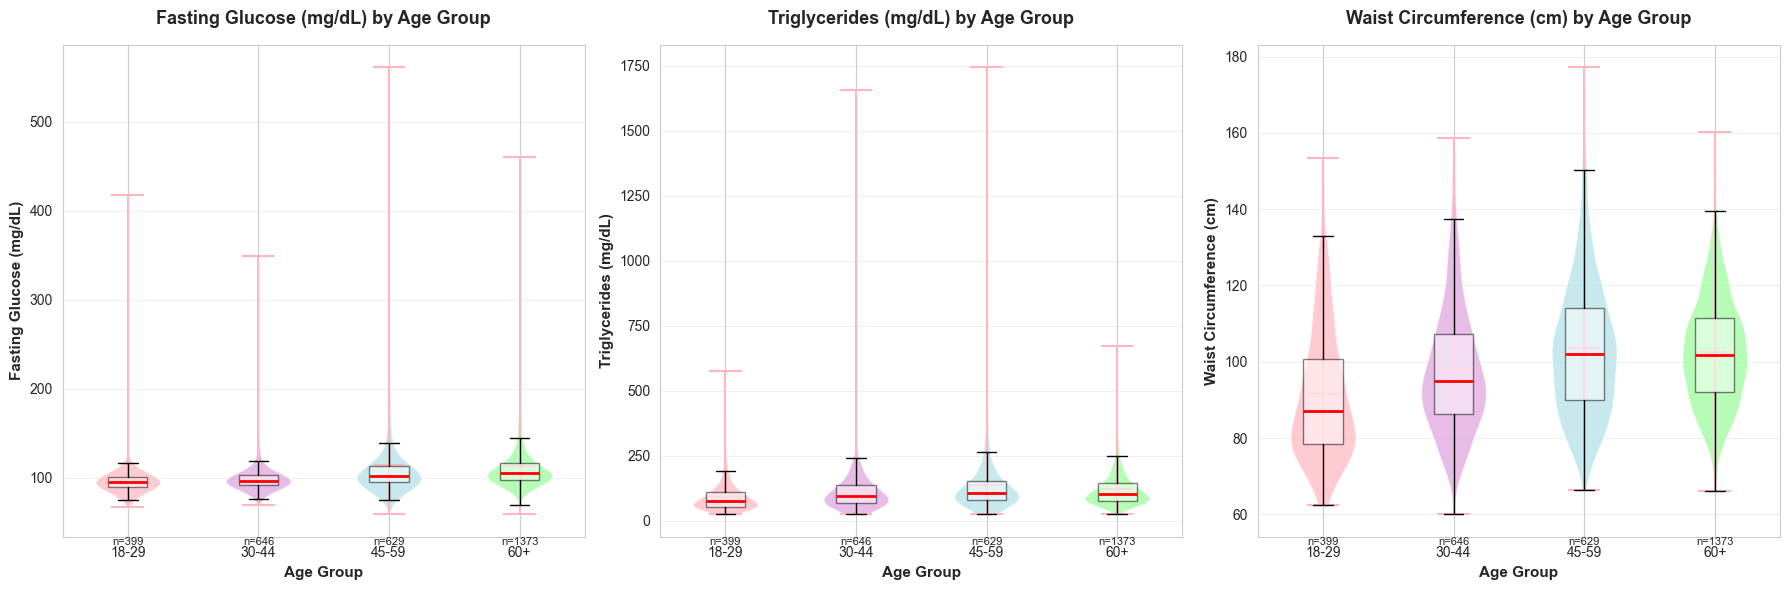

In [8]:
# Visualization - Core Variables by Age Group
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/metabolic_by_age_group.png'
    else:
        save_path = '../results/figures/metabolic_by_age_group.png'
else:
    save_path = 'results/figures/metabolic_by_age_group.png'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

var_labels = {
    'LBXGLU': 'Fasting Glucose (mg/dL)',
    'LBXTLG': 'Triglycerides (mg/dL)',
    'BMXWAIST': 'Waist Circumference (cm)'
}

pastel_age_colors = ['#FFB6C1', '#DDA0DD', '#B0E0E6', '#98FB98']
age_groups_sorted = sorted(df['age_group'].dropna().unique())

for idx, var in enumerate(core_vars):
    ax = axes[idx]
    
    data_by_age = [df[df['age_group']==ag][var].dropna().values for ag in age_groups_sorted]
    
    # Violin plot
    parts = ax.violinplot(data_by_age, positions=range(len(age_groups_sorted)),
                          showmeans=True, showmedians=True)
    
    # Color violins
    for i, body in enumerate(parts['bodies']):
        body.set_facecolor(pastel_age_colors[i % len(pastel_age_colors)])
        body.set_alpha(0.7)
    
    # Box plot overlay
    ax.boxplot(data_by_age, positions=range(len(age_groups_sorted)), widths=0.3,
               patch_artist=True, boxprops=dict(facecolor='white', alpha=0.5),
               medianprops=dict(color='red', linewidth=2), showfliers=False)
    
    ax.set_xticks(range(len(age_groups_sorted)))
    ax.set_xticklabels(age_groups_sorted)
    ax.set_xlabel('Age Group', fontsize=11, fontweight='bold')
    ax.set_ylabel(var_labels[var], fontsize=11, fontweight='bold')
    ax.set_title(f"{var_labels[var]} by Age Group", fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Sample sizes
    for i, values in enumerate(data_by_age):
        ax.text(i, ax.get_ylim()[0], f"n={len(values)}", ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

Saved: ../../results/figures/metabolic_by_sex.png


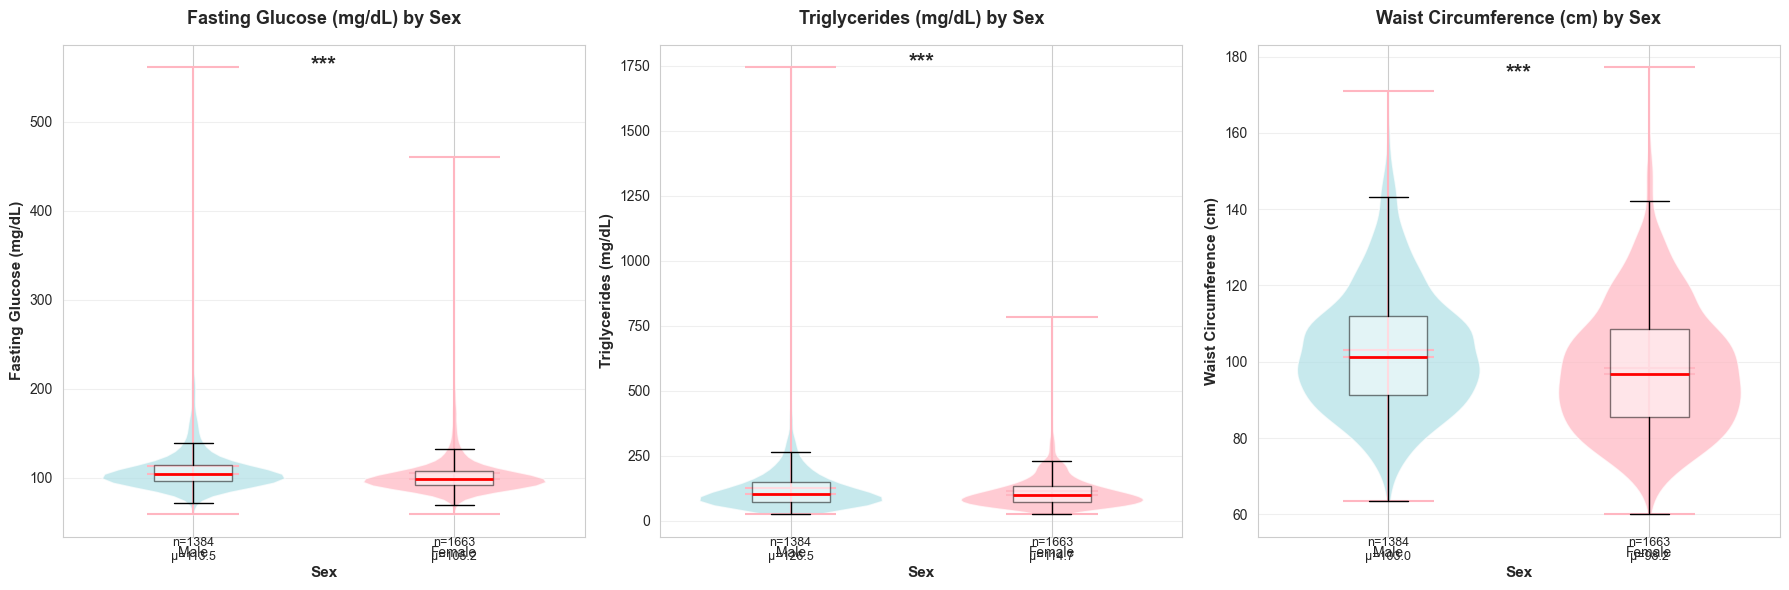

In [10]:
# Visualization - Core Variables by Sex
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/metabolic_by_sex.png'
    else:
        save_path = '../results/figures/metabolic_by_sex.png'
else:
    save_path = 'results/figures/metabolic_by_sex.png'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

pastel_sex_colors = ['#B0E0E6', '#FFB6C1']

for idx, var in enumerate(core_vars):
    ax = axes[idx]
    
    data_by_sex = [df[df['sex_label']==sex][var].dropna().values for sex in ['Male', 'Female']]
    
    # Violin plot
    parts = ax.violinplot(data_by_sex, positions=[0, 1], showmeans=True, showmedians=True, widths=0.7)
    
    # Color violins
    for pc, color in zip(parts['bodies'], pastel_sex_colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    # Box plot overlay
    ax.boxplot(data_by_sex, positions=[0, 1], widths=0.3, patch_artist=True,
               boxprops=dict(facecolor='white', alpha=0.5),
               medianprops=dict(color='red', linewidth=2), showfliers=False)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_xlabel('Sex', fontsize=11, fontweight='bold')
    ax.set_ylabel(var_labels[var], fontsize=11, fontweight='bold')
    ax.set_title(f"{var_labels[var]} by Sex", fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Sample sizes and means
    for i, sex in enumerate(['Male', 'Female']):
        n = len(df[df['sex_label']==sex][var].dropna())
        mean_val = df[df['sex_label']==sex][var].mean()
        ax.text(i, ax.get_ylim()[0], f"n={n}\nμ={mean_val:.1f}", ha='center', va='top', fontsize=9)
    
    # Calculate p-value for significance stars
    male_data = df[df['sex_label']=='Male'][var].dropna().values
    female_data = df[df['sex_label']=='Female'][var].dropna().values
    t_stat, p_val = stats.ttest_ind(male_data, female_data)
    
    if p_val < 0.001:
        ax.text(0.5, ax.get_ylim()[1]*0.95, '***', ha='center', fontsize=16, fontweight='bold')
    elif p_val < 0.01:
        ax.text(0.5, ax.get_ylim()[1]*0.95, '**', ha='center', fontsize=16, fontweight='bold')
    elif p_val < 0.05:
        ax.text(0.5, ax.get_ylim()[1]*0.95, '*', ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

Saved: ../../results/figures/metabolic_by_race.png


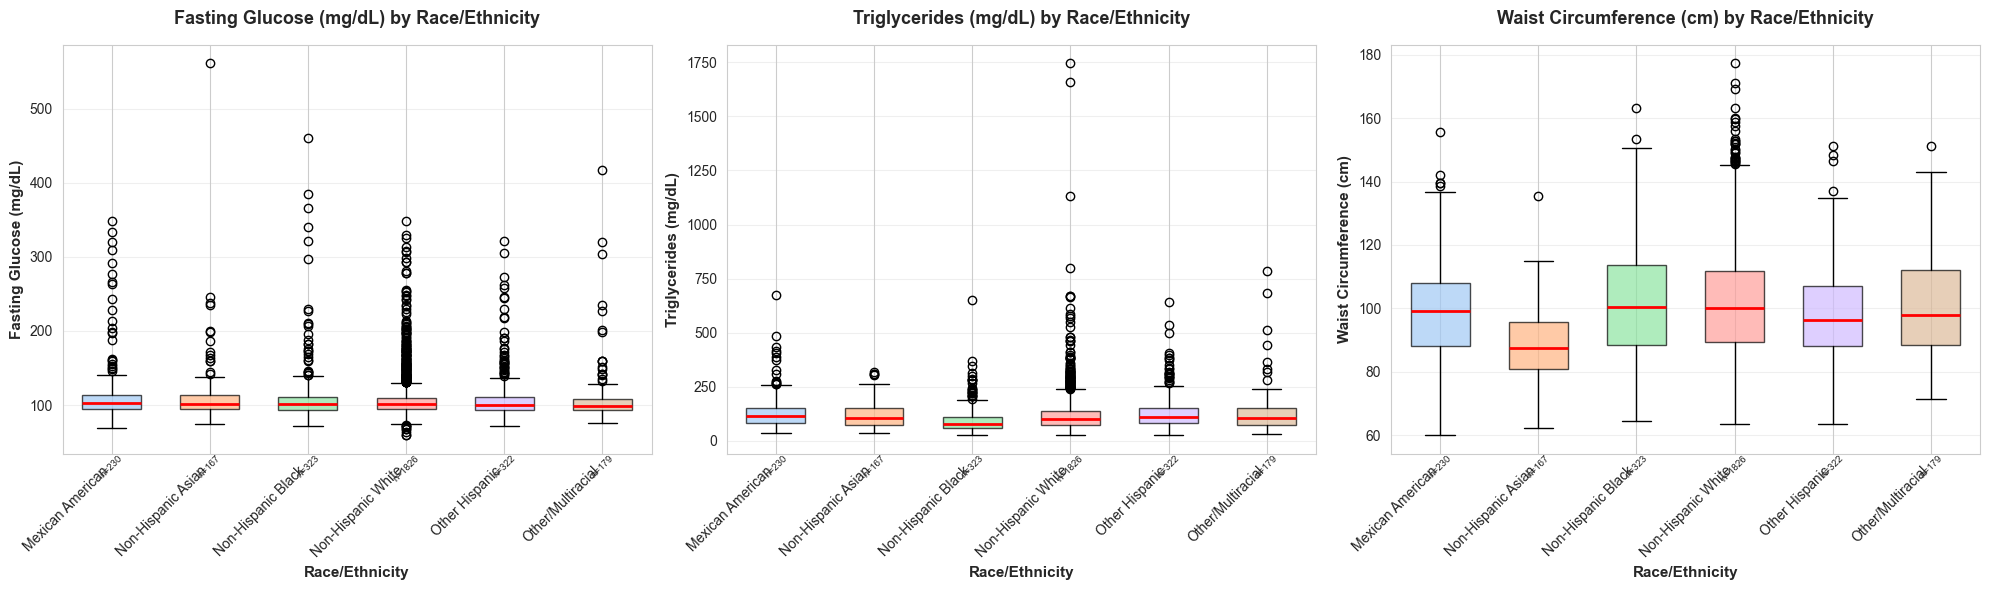

In [11]:
# Visualization - Core Variables by Race/Ethnicity
if 'race_ethnicity' in df.columns:
    from pathlib import Path
    current = Path.cwd()
    
    if 'notebooks' in str(current):
        if 'explore_data' in str(current):
            save_path = '../../results/figures/metabolic_by_race.png'
        else:
            save_path = '../results/figures/metabolic_by_race.png'
    else:
        save_path = 'results/figures/metabolic_by_race.png'
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    race_groups = sorted(df['race_ethnicity'].dropna().unique())
    n_groups = len(race_groups)
    pastel_race_colors = sns.color_palette("pastel", n_groups)
    
    for idx, var in enumerate(core_vars):
        ax = axes[idx]
        
        data_by_race = [df[df['race_ethnicity']==race][var].dropna().values for race in race_groups]
        
        bp = ax.boxplot(data_by_race, positions=range(n_groups), widths=0.6,
                        patch_artist=True, medianprops=dict(color='red', linewidth=2))
        
        # Color boxes
        for patch, color in zip(bp['boxes'], pastel_race_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_xticks(range(n_groups))
        ax.set_xticklabels(race_groups, rotation=45, ha='right')
        ax.set_xlabel('Race/Ethnicity', fontsize=11, fontweight='bold')
        ax.set_ylabel(var_labels[var], fontsize=11, fontweight='bold')
        ax.set_title(f"{var_labels[var]} by Race/Ethnicity", fontsize=13, fontweight='bold', pad=15)
        ax.grid(axis='y', alpha=0.3)
        
        # Sample sizes
        for i, race in enumerate(race_groups):
            n = len(df[df['race_ethnicity']==race][var].dropna())
            ax.text(i, ax.get_ylim()[0], f"n={n}", ha='center', va='top', fontsize=7, rotation=45)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
else:
    print("Race/ethnicity variable not available")

In [12]:
# Interaction Analysis - Age × Sex
interaction_data = df.groupby(['age_group', 'sex_label'])[core_vars].mean().reset_index()

print("Mean values by Age Group × Sex:")
print(interaction_data.round(2))

# Two-way interaction test
from scipy.stats import f_oneway

print("\nTwo-way ANOVA: Age × Sex Interaction")
for var in core_vars:
    print(f"\n{var}:")
    
    # Age effects within each sex
    male_age_groups = [df[(df['sex_label']=='Male') & (df['age_group']==ag)][var].dropna().values 
                       for ag in sorted(df['age_group'].unique())]
    female_age_groups = [df[(df['sex_label']=='Female') & (df['age_group']==ag)][var].dropna().values 
                         for ag in sorted(df['age_group'].unique())]
    
    f_male, p_male = f_oneway(*male_age_groups)
    f_female, p_female = f_oneway(*female_age_groups)
    
    print(f"  Age effect in Males: F={f_male:.3f}, p={p_male:.4e}")
    print(f"  Age effect in Females: F={f_female:.3f}, p={p_female:.4e}")
    
    if p_male < 0.05 and p_female < 0.05:
        print(f"  → Age effect significant in BOTH sexes")
    elif p_male < 0.05:
        print(f"  → Age effect significant only in MALES")
    elif p_female < 0.05:
        print(f"  → Age effect significant only in FEMALES")
    else:
        print(f"  → Age effect not significant in either sex")

Mean values by Age Group × Sex:
  age_group sex_label  LBXGLU  LBXTLG  BMXWAIST
0     18-29    Female   93.68   85.06     90.78
1     18-29      Male  102.81  100.34     92.51
2     30-44    Female   99.13  104.13     96.95
3     30-44      Male  104.82  135.41     99.48
4     45-59    Female  108.56  128.43    100.90
5     45-59      Male  121.19  149.20    106.80
6       60+    Female  109.96  122.15     99.78
7       60+      Male  117.03  120.40    105.95

Two-way ANOVA: Age × Sex Interaction

LBXGLU:
  Age effect in Males: F=15.820, p=4.0689e-10
  Age effect in Females: F=27.387, p=2.7591e-17
  → Age effect significant in BOTH sexes

LBXTLG:
  Age effect in Males: F=9.776, p=2.2046e-06
  Age effect in Females: F=24.234, p=2.3917e-15
  → Age effect significant in BOTH sexes

BMXWAIST:
  Age effect in Males: F=45.840, p=3.0755e-28
  Age effect in Females: F=20.217, p=7.2015e-13
  → Age effect significant in BOTH sexes


Saved: ../../results/figures/age_sex_interaction.png


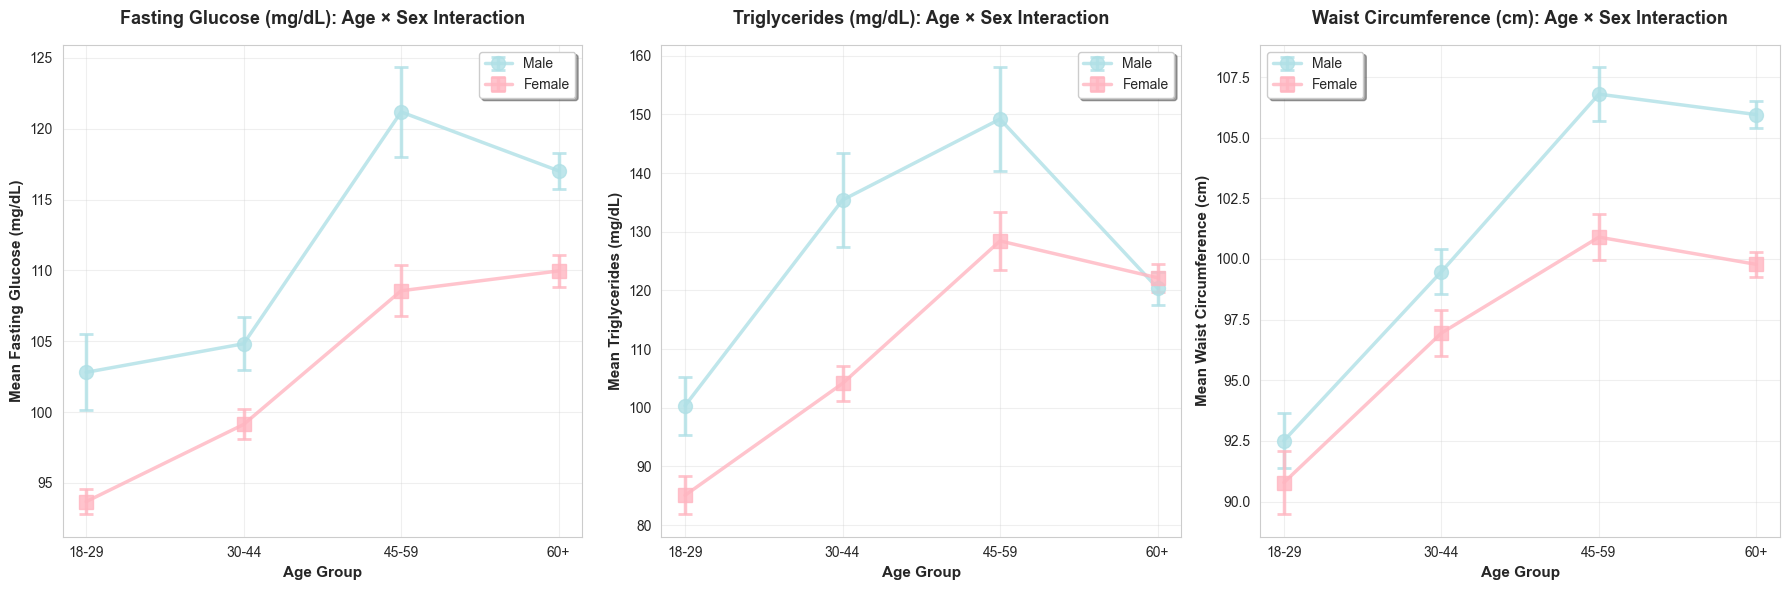

In [13]:
# Visualization - Age × Sex Interaction Plots
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/age_sex_interaction.png'
    else:
        save_path = '../results/figures/age_sex_interaction.png'
else:
    save_path = 'results/figures/age_sex_interaction.png'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

male_color = '#B0E0E6'
female_color = '#FFB6C1'

for idx, var in enumerate(core_vars):
    ax = axes[idx]
    
    male_data = df[df['sex_label']=='Male'].groupby('age_group')[var].agg(['mean', 'sem']).reset_index()
    female_data = df[df['sex_label']=='Female'].groupby('age_group')[var].agg(['mean', 'sem']).reset_index()
    
    male_data = male_data.sort_values('age_group')
    female_data = female_data.sort_values('age_group')
    
    x_pos = range(len(male_data))
    
    ax.errorbar(x_pos, male_data['mean'], yerr=male_data['sem'], 
                marker='o', markersize=10, linewidth=2.5, capsize=5, capthick=2,
                color=male_color, label='Male', alpha=0.8)
    
    ax.errorbar(x_pos, female_data['mean'], yerr=female_data['sem'], 
                marker='s', markersize=10, linewidth=2.5, capsize=5, capthick=2,
                color=female_color, label='Female', alpha=0.8)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(male_data['age_group'].values)
    ax.set_xlabel('Age Group', fontsize=11, fontweight='bold')
    ax.set_ylabel(f"Mean {var_labels[var]}", fontsize=11, fontweight='bold')
    ax.set_title(f"{var_labels[var]}: Age × Sex Interaction", fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [14]:
# MetS Prevalence by Demographics

def calculate_prevalence_ci(data, group_var):
    """Calculate prevalence with 95% CI"""
    prev_data = []
    
    for group in data[group_var].dropna().unique():
        subset = data[data[group_var]==group]
        n = len(subset)
        k = subset['mets_full'].sum()
        p = k / n if n > 0 else 0
        
        # Wilson score interval
        z = 1.96
        denominator = 1 + z**2/n
        centre = (p + z**2/(2*n)) / denominator
        adjustment = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denominator
        ci_lower = max(0, centre - adjustment)
        ci_upper = min(1, centre + adjustment)
        
        prev_data.append({
            'Group': group,
            'N': n,
            'Cases': int(k),
            'Prevalence_%': p * 100,
            'CI_Lower_%': ci_lower * 100,
            'CI_Upper_%': ci_upper * 100
        })
    
    return pd.DataFrame(prev_data)

# By Age Group
print("Full MetS Prevalence by Age Group:")
age_prev = calculate_prevalence_ci(df, 'age_group')
age_prev = age_prev.sort_values('Group')
print(age_prev.round(2))

# By Sex
print("\nFull MetS Prevalence by Sex:")
sex_prev = calculate_prevalence_ci(df, 'sex_label')
print(sex_prev.round(2))

# By Race/Ethnicity
if 'race_ethnicity' in df.columns:
    print("\nFull MetS Prevalence by Race/Ethnicity:")
    race_prev = calculate_prevalence_ci(df, 'race_ethnicity')
    race_prev = race_prev.sort_values('Prevalence_%', ascending=False)
    print(race_prev.round(2))

Full MetS Prevalence by Age Group:
   Group     N  Cases  Prevalence_%  CI_Lower_%  CI_Upper_%
3  18-29   399     10          2.51        1.37        4.55
0  30-44   646     53          8.20        6.33       10.58
2  45-59   629    100         15.90       13.25       18.96
1    60+  1373    218         15.88       14.04       17.91

Full MetS Prevalence by Sex:
    Group     N  Cases  Prevalence_%  CI_Lower_%  CI_Upper_%
0    Male  1384    168         12.14       10.52       13.96
1  Female  1663    213         12.81       11.29       14.50

Full MetS Prevalence by Race/Ethnicity:
                Group     N  Cases  Prevalence_%  CI_Lower_%  CI_Upper_%
3    Mexican American   230     35         15.22       11.15       20.43
2      Other Hispanic   322     48         14.91       11.43       19.21
1  Non-Hispanic White  1826    238         13.03       11.57       14.66
5   Other/Multiracial   179     23         12.85        8.72       18.54
4  Non-Hispanic Black   323     25          7.

In [15]:
# Chi-Square Tests for MetS Prevalence by Demographics

print("Chi-Square Tests: MetS Independence from Demographics\n")

# Test 1: MetS × Age Group
print("Test 1: Full MetS by Age Group")
contingency_age = pd.crosstab(df['age_group'], df['mets_full'])
chi2, p_val, dof, expected = chi2_contingency(contingency_age)
print(f"Chi-square: {chi2:.3f}, p-value: {p_val:.4e}, df: {dof}")
if p_val < 0.05:
    print("Significant association between age and MetS")
else:
    print("No significant association")

# Test 2: MetS × Sex
print("\nTest 2: Full MetS by Sex")
contingency_sex = pd.crosstab(df['sex_label'], df['mets_full'])
chi2, p_val, dof, expected = chi2_contingency(contingency_sex)
print(f"Chi-square: {chi2:.3f}, p-value: {p_val:.4e}, df: {dof}")
if p_val < 0.05:
    print("Significant association between sex and MetS")
else:
    print("No significant association")

# Test 3: MetS × Race/Ethnicity
if 'race_ethnicity' in df.columns:
    print("\nTest 3: Full MetS by Race/Ethnicity")
    contingency_race = pd.crosstab(df['race_ethnicity'], df['mets_full'])
    chi2, p_val, dof, expected = chi2_contingency(contingency_race)
    print(f"Chi-square: {chi2:.3f}, p-value: {p_val:.4e}, df: {dof}")
    if p_val < 0.05:
        print("Significant association between race/ethnicity and MetS")
    else:
        print("No significant association")

Chi-Square Tests: MetS Independence from Demographics

Test 1: Full MetS by Age Group
Chi-square: 68.276, p-value: 9.9846e-15, df: 3
Significant association between age and MetS

Test 2: Full MetS by Sex
Chi-square: 0.251, p-value: 6.1619e-01, df: 1
No significant association

Test 3: Full MetS by Race/Ethnicity
Chi-square: 14.753, p-value: 1.1469e-02, df: 5
Significant association between race/ethnicity and MetS


In [16]:
# Calculate Odds Ratios for High-Risk Groups

def calculate_odds_ratio(data, group_var, reference_group):
    """Calculate odds ratios with 95% CI for each group vs reference"""
    results = []
    
    groups = data[group_var].dropna().unique()
    
    # Reference group stats
    ref_data = data[data[group_var]==reference_group]
    ref_cases = ref_data['mets_full'].sum()
    ref_controls = len(ref_data) - ref_cases
    
    for group in groups:
        if group == reference_group:
            continue
            
        group_data = data[data[group_var]==group]
        group_cases = group_data['mets_full'].sum()
        group_controls = len(group_data) - group_cases
        
        # Calculate OR
        if ref_controls > 0 and group_controls > 0:
            OR = (group_cases * ref_controls) / (group_controls * ref_cases) if ref_cases > 0 and group_cases > 0 else 0
            
            # 95% CI using Woolf method
            if OR > 0 and group_cases > 0 and ref_cases > 0:
                log_or = np.log(OR)
                se_log_or = np.sqrt(1/group_cases + 1/group_controls + 1/ref_cases + 1/ref_controls)
                ci_lower = np.exp(log_or - 1.96 * se_log_or)
                ci_upper = np.exp(log_or + 1.96 * se_log_or)
            else:
                ci_lower = ci_upper = np.nan
        else:
            OR = ci_lower = ci_upper = np.nan
        
        results.append({
            'Group': group,
            'Cases': int(group_cases),
            'N': len(group_data),
            'Odds_Ratio': OR,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'Reference': reference_group
        })
    
    return pd.DataFrame(results)

# Odds ratios by age group (reference: youngest group)
print("Odds Ratios for Full MetS by Age Group")
youngest_age = sorted(df['age_group'].unique())[0]
age_or = calculate_odds_ratio(df, 'age_group', youngest_age)
print(age_or.round(2))

# Odds ratios by sex (reference: Female)
print("\nOdds Ratios for Full MetS by Sex")
sex_or = calculate_odds_ratio(df, 'sex_label', 'Female')
print(sex_or.round(2))

# Odds ratios by race/ethnicity (reference: Non-Hispanic White)
if 'race_ethnicity' in df.columns and 'Non-Hispanic White' in df['race_ethnicity'].values:
    print("\nOdds Ratios for Full MetS by Race/Ethnicity")
    race_or = calculate_odds_ratio(df, 'race_ethnicity', 'Non-Hispanic White')
    print(race_or.round(2))

Odds Ratios for Full MetS by Age Group
   Group  Cases     N  Odds_Ratio  CI_Lower  CI_Upper Reference
0  30-44     53   646        3.48      1.75      6.92     18-29
1    60+    218  1373        7.34      3.86     13.98     18-29
2  45-59    100   629        7.35      3.79     14.27     18-29

Odds Ratios for Full MetS by Sex
  Group  Cases     N  Odds_Ratio  CI_Lower  CI_Upper Reference
0  Male    168  1384        0.94      0.76      1.17    Female

Odds Ratios for Full MetS by Race/Ethnicity
                Group  Cases    N  Odds_Ratio  CI_Lower  CI_Upper  \
0  Non-Hispanic Asian     12  167        0.52      0.28      0.94   
1      Other Hispanic     48  322        1.17      0.84      1.63   
2    Mexican American     35  230        1.20      0.82      1.76   
3  Non-Hispanic Black     25  323        0.56      0.36      0.86   
4   Other/Multiracial     23  179        0.98      0.62      1.56   

            Reference  
0  Non-Hispanic White  
1  Non-Hispanic White  
2  Non-Hispan

Saved: ../../results/figures/mets_prevalence_demographics.png


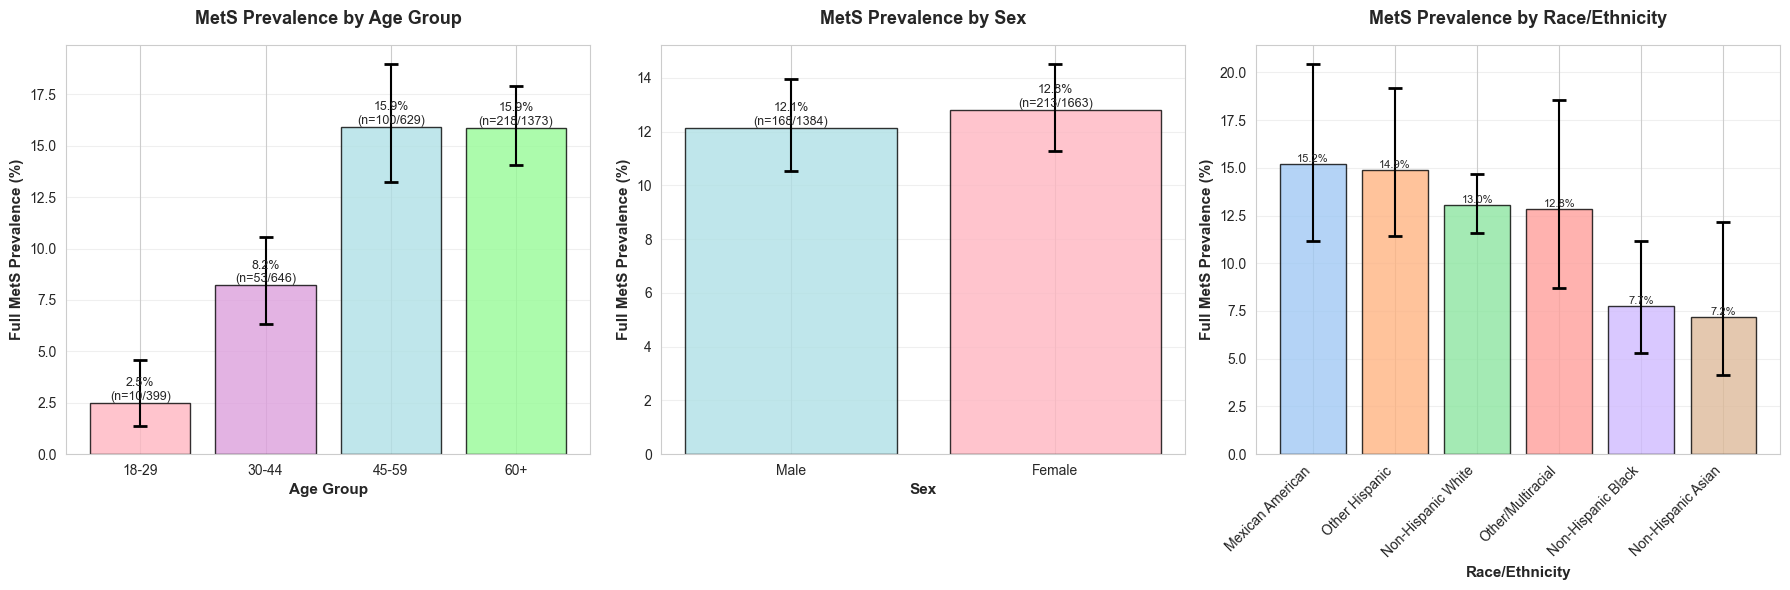

In [17]:
# Visualization - MetS Prevalence by Demographics
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/mets_prevalence_demographics.png'
    else:
        save_path = '../results/figures/mets_prevalence_demographics.png'
else:
    save_path = 'results/figures/mets_prevalence_demographics.png'

# Determine number of subplots based on available data
n_plots = 2 if 'race_ethnicity' not in df.columns else 3
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))

if n_plots == 2:
    axes = list(axes)

# Plot 1: By Age Group
ax1 = axes[0]
age_prev_plot = age_prev.sort_values('Group')
x_pos = range(len(age_prev_plot))
bars = ax1.bar(x_pos, age_prev_plot['Prevalence_%'], color=pastel_age_colors[:len(x_pos)], 
               alpha=0.8, edgecolor='black')
ax1.errorbar(x_pos, age_prev_plot['Prevalence_%'], 
             yerr=[age_prev_plot['Prevalence_%'] - age_prev_plot['CI_Lower_%'],
                   age_prev_plot['CI_Upper_%'] - age_prev_plot['Prevalence_%']],
             fmt='none', color='black', capsize=5, capthick=2)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(age_prev_plot['Group'])
ax1.set_xlabel('Age Group', fontsize=11, fontweight='bold')
ax1.set_ylabel('Full MetS Prevalence (%)', fontsize=11, fontweight='bold')
ax1.set_title('MetS Prevalence by Age Group', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)

for i, (bar, row) in enumerate(zip(bars, age_prev_plot.itertuples())):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={row.Cases}/{row.N})',
            ha='center', va='bottom', fontsize=9)

# Plot 2: By Sex
ax2 = axes[1]
x_pos = range(len(sex_prev))
bars = ax2.bar(x_pos, sex_prev['Prevalence_%'], color=pastel_sex_colors, 
               alpha=0.8, edgecolor='black')
ax2.errorbar(x_pos, sex_prev['Prevalence_%'],
             yerr=[sex_prev['Prevalence_%'] - sex_prev['CI_Lower_%'],
                   sex_prev['CI_Upper_%'] - sex_prev['Prevalence_%']],
             fmt='none', color='black', capsize=5, capthick=2)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sex_prev['Group'])
ax2.set_xlabel('Sex', fontsize=11, fontweight='bold')
ax2.set_ylabel('Full MetS Prevalence (%)', fontsize=11, fontweight='bold')
ax2.set_title('MetS Prevalence by Sex', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

for i, (bar, row) in enumerate(zip(bars, sex_prev.itertuples())):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={row.Cases}/{row.N})',
            ha='center', va='bottom', fontsize=9)

# Plot 3: By Race/Ethnicity (if available)
if n_plots == 3:
    ax3 = axes[2]
    x_pos = range(len(race_prev))
    colors_race = sns.color_palette("pastel", len(race_prev))
    bars = ax3.bar(x_pos, race_prev['Prevalence_%'], color=colors_race, 
                   alpha=0.8, edgecolor='black')
    ax3.errorbar(x_pos, race_prev['Prevalence_%'],
                 yerr=[race_prev['Prevalence_%'] - race_prev['CI_Lower_%'],
                       race_prev['CI_Upper_%'] - race_prev['Prevalence_%']],
                 fmt='none', color='black', capsize=5, capthick=2)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(race_prev['Group'], rotation=45, ha='right')
    ax3.set_xlabel('Race/Ethnicity', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Full MetS Prevalence (%)', fontsize=11, fontweight='bold')
    ax3.set_title('MetS Prevalence by Race/Ethnicity', fontsize=13, fontweight='bold', pad=15)
    ax3.grid(axis='y', alpha=0.3)
    
    for i, (bar, row) in enumerate(zip(bars, race_prev.itertuples())):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [18]:
# Save all demographic summary tables
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        table_path = '../../results/tables/'
    else:
        table_path = '../results/tables/'
else:
    table_path = 'results/tables/'

# Save ANOVA results
anova_df.to_csv(table_path + 'anova_age_groups.csv', index=False)
print(f"Saved: {table_path}anova_age_groups.csv")

# Save t-test results
ttest_df.to_csv(table_path + 'ttest_sex_differences.csv', index=False)
print(f"Saved: {table_path}ttest_sex_differences.csv")

# Save race ANOVA if available
if 'race_ethnicity' in df.columns:
    anova_race_df.to_csv(table_path + 'anova_race_ethnicity.csv', index=False)
    print(f"Saved: {table_path}anova_race_ethnicity.csv")

# Save prevalence tables
age_prev.to_csv(table_path + 'mets_prevalence_by_age.csv', index=False)
sex_prev.to_csv(table_path + 'mets_prevalence_by_sex.csv', index=False)
if 'race_ethnicity' in df.columns:
    race_prev.to_csv(table_path + 'mets_prevalence_by_race.csv', index=False)

print(f"Saved: {table_path}mets_prevalence_by_age.csv")
print(f"Saved: {table_path}mets_prevalence_by_sex.csv")
if 'race_ethnicity' in df.columns:
    print(f"Saved: {table_path}mets_prevalence_by_race.csv")

# Save odds ratios
age_or.to_csv(table_path + 'odds_ratios_age.csv', index=False)
sex_or.to_csv(table_path + 'odds_ratios_sex.csv', index=False)
if 'race_ethnicity' in df.columns:
    race_or.to_csv(table_path + 'odds_ratios_race.csv', index=False)

print(f"Saved: {table_path}odds_ratios_age.csv")
print(f"Saved: {table_path}odds_ratios_sex.csv")
if 'race_ethnicity' in df.columns:
    print(f"Saved: {table_path}odds_ratios_race.csv")

print("\nAll demographic stratification tables saved!")

NameError: name 'anova_df' is not defined